# Library matching with DreaMS embeddings and MassSpecGym

## 1. Introduction

Library matching is a fundamental task in mass spectrometry, where the goal is to annotate an **unknown (query) spectrum** by finding the most similar spectrum in a **reference library**.  
This process links a query MS/MS spectrum to a known molecular structure, enabling identification or hypothesis generation for unknown compounds in biological or environmental samples.

Traditional library matching methods rely on heuristic spectral similarity metrics such as **modified cosine similarity**.  
However, as shown in our paper ([DreaMS](https://www.nature.com/articles/s41587-025-02663-3)), **DreaMS embeddings** enable more accurate and sensitive spectrum-to-spectrum comparisons.  
This approach is especially effective for challenging cases, such as identifying **analogs** or previously unseen molecules.

In this tutorial, we demonstrate **library matching with DreaMS embeddings** using the [MassSpecGym dataset](https://arxiv.org/abs/2410.23326), which serves as a standardized, large-scale mass spectra reference library.

In [1]:
import sys
from pathlib import Path

# assume this notebook lives in notebooks/, so parent() is the repo root
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
from tqdm import tqdm

from dreams.utils.data import MSData
from dreams.api import dreams_embeddings
from sklearn.metrics.pairwise import cosine_similarity
import dreams.utils.spectra as su

import rdkit.Chem as Chem

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## 2. Preparing Reference and Query Data

To perform library matching, you need two things:

- A **spectral library** for searching (here: **MassSpecGym**)
- A set of **query spectra** (your own data, already processed in previous tutorials: `Piper_sirius_all_annotated_high_quality_dedup.hdf5`)
- 
### 2.1 Download the MassSpecGym Reference Library

For this tutorial, we use the **MassSpecGym library** as our reference.  
This dataset is freely available on **Hugging Face Datasets**.

**Required file:**  
`MassSpecGym.mgf`

**Instructions:**

1. Download the file `MassSpecGym.mgf` from this Hugging Face page:  
   [https://huggingface.co/datasets/roman-bushuiev/MassSpecGym](https://huggingface.co/datasets/roman-bushuiev/MassSpecGym)  
   You’ll find it under:  
   [data/auxiliary/MassSpecGym.mgf](https://huggingface.co/datasets/roman-bushuiev/MassSpecGym/tree/main/data/auxiliary)

2. Place it in your local project under:  
   `data/massspecgym/MassSpecGym.mgf`  
   *(Create the `massspecgym/` subfolder inside your `data/` directory if needed)*

> 📝 **Note:**  
> The first time you run the notebook, the `.mgf` file will be converted to a `.hdf5` file for efficient downstream processing (see below).

### 2.2 Define All Input/Output Paths

Now, set up the paths to your **reference library** and **query data**:

In [2]:
# 1a) Path to MassSpecGym spectral library (MGF and derived files)
mgf_path      = PROJECT_ROOT / "data" / "massspecgym" / "MassSpecGym.mgf"
lib_h5        = mgf_path.with_suffix(".hdf5")  # will be created automatically if not present
lib_emb_path  = lib_h5.with_name(lib_h5.stem + "_dreams_emb.npy")  # DreaMS embeddings

# 1b) Path to query spectra (your deduplicated and QC-filtered data from previous steps)
query_h5       = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated_high_quality_dedup.hdf5"
query_emb_path = query_h5.with_name(query_h5.stem + "_dreams_emb.npy")

# 1c) Results folder (all output CSVs)
results_folder = PROJECT_ROOT / "results"
results_folder.mkdir(exist_ok=True)

**What these paths do:**

- `mgf_path`: Points to the downloaded **MassSpecGym** reference library (MGF format).
- `lib_h5`: The **HDF5** version of the library.
- `lib_emb_path`: Where the **pre-computed** (or to-be-computed) **DreaMS embeddings** for the library are saved.
- `query_h5`: The **deduplicated, high-quality spectra** from your own data (created in previous tutorials).
- `query_emb_path`: Where your **query spectra’s DreaMS embeddings** are (or will be) saved.
- `results_folder`: Where all **outputs** (e.g., top matches CSV) will be saved.

> **Tip:**  
> If you use different paths or file names, update the code above to match.

## 3. What is MassSpecGym?

**MassSpecGym** is the first comprehensive benchmark dataset designed for the **discovery and identification of molecules** from **MS/MS** (tandem mass spectrometry) data.  
It contains over **231,000 high-quality, labeled MS/MS spectra** representing **29,000 unique molecular structures**, making it the largest and most standardized public resource of its kind.

MassSpecGym is structured around three core annotation challenges:

- **De novo molecular structure generation**:  
  Predict the molecular structure (graph) directly from an MS/MS spectrum, this is the classic “structure-from-spectrum” problem.

- **Molecule retrieval (library matching)**:  
  Retrieve the most similar molecule from a molecular database, given a query mass spectrum.  
  Rather than generating a new structure, this task focuses on finding the best library match.

- **Spectrum simulation**:  
  The inverse challenge, predict the expected MS/MS spectrum for a given molecular structure.

MassSpecGym is notable for a **strict train/validation/test split** that prevents data leakage.  
Splitting is performed using the **molecular graph edit distance (MCES)** to ensure that **structurally related compounds do not cross splits**.  
This design enables **fair benchmarking** and robust evaluation of machine learning models.

**Learn more:**  
- [MassSpecGym paper](https://arxiv.org/abs/2410.23326)  
- [MassSpecGym repository](https://github.com/pluskal-lab/MassSpecGym)

## 4. Loading the MassSpecGym library

The following cell will check if a **pre-processed HDF5 version** of the MassSpecGym library already exists on your disk.  
If so, it will load this fast, binary format in seconds.  
If not, it will parse the raw `.mgf` file and automatically convert it to `.hdf5` for future use.

In [4]:
if lib_h5.exists():
    msdata_lib = MSData.from_hdf5(lib_h5, in_mem=True)
else:
    msdata_lib = MSData.load(
        mgf_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )
print(f"Library loaded: {len(msdata_lib)} spectra → {lib_h5.name}")
print("Columns:", msdata_lib.columns())

Loading dataset MassSpecGym into memory (231104 spectra)...
Library loaded: 231104 spectra → MassSpecGym.hdf5
Columns: ['COLLISION_ENERGY', 'FOLD', 'FORMULA', 'IDENTIFIER', 'INCHIKEY', 'INSTRUMENT_TYPE', 'PARENT_MASS', 'PRECURSOR_FORMULA', 'SIMULATION_CHALLENGE', 'adduct', 'precursor_mz', 'smiles', 'spectrum']


## 5. Computing DreaMS embeddings for library spectra

**DreaMS** (Deep Representations Empowering the Annotation of Mass Spectra) is a **transformer-based model** trained on millions of experimental MS/MS spectra.  
It produces a **1024-dimensional embedding** (vector) for every input spectrum.

**What does this mean in practice?**

- Each spectrum is transformed into a **dense, fixed-length vector** that captures both the **structural** and **fragmentation** features of the molecule.
- Spectra with similar underlying chemistry and fragmentation patterns are **close together** in this "embedding space."
- **Cosine similarity** between embeddings is a robust, data-driven measure of spectrum-to-spectrum similarity.

**Why use DreaMS embeddings for library matching?**

- **Embedding-based matching** is more sensitive and accurate than traditional spectral similarity metrics (e.g., modified cosine), especially in **large and diverse datasets**.
- The model can reliably identify both **exact matches** and **structural analogs**.
- Embeddings are **robust** to instrument noise, acquisition settings, and sample variability.
- **Fast search**: all comparisons are reduced to **vector math**, and scalable to **millions of spectra**.

> **Note:**  
> DreaMS requires the input *mass spectra* **and** their *precursor m/z* values.

The following code will compute (or load, if already saved) the **DreaMS embeddings** for all library spectra.  
On first run, this may take **up to an hour**, but saved embeddings are reused **instantly**.

In [5]:
if lib_emb_path.exists():
    embs_lib = np.load(lib_emb_path)
    print("Loaded saved library embeddings:", embs_lib.shape)
else:
    embs_lib = dreams_embeddings(msdata_lib)
    np.save(lib_emb_path, embs_lib)
    print("Computed & saved library embeddings:", embs_lib.shape)

Loaded saved library embeddings: (231104, 1024)


## 6. Loading your query spectra and computing DreaMS embeddings

For this tutorial, we use the **preprocessed, deduplicated, and high-quality spectra** prepared in **Tutorials 1 & 2**.

If you have not completed the preprocessing steps, you can use your own raw `.mgf` or `.mzML` file here — just create an `MSData` object as before:

In [6]:
if query_h5.exists():
    msdata_q = MSData.from_hdf5(query_h5, in_mem=True)
else:
    raise FileNotFoundError(f"Expected dedup HDF5 at {query_h5}")
print(f"Query loaded:   {len(msdata_q)} spectra → {query_h5.name}")

Loading dataset Piper_sirius_all_annotated_high_quality_dedup into memory (2799 spectra)...
Query loaded:   2799 spectra → Piper_sirius_all_annotated_high_quality_dedup.hdf5


## 7. Computing pairwise similarity

Now we load the **query `MSData`** and compute (or load) its **DreaMS embeddings**.  
Embeddings are required for all **downstream similarity searches**, without them, **library matching will not work**.

In [7]:
if query_emb_path.exists():
    embs_q = np.load(query_emb_path)
    print("Loaded saved query embeddings:", embs_q.shape)
else:
    embs_q = dreams_embeddings(msdata_q)
    np.save(query_emb_path, embs_q)
    print("Computed & saved query embeddings:", embs_q.shape)

Computing DreaMS embedding: 100%|██████████| 2799/2799 [01:04<00:00, 43.55it/s]


Computed & saved query embeddings: (2799, 1024)


#### Now we compute pairwise similarity between our mass spectra and spectra from MassSpecGym

With both sets of **DreaMS embeddings** (your query and the MassSpecGym library), we now compute the **all-vs-all cosine similarity matrix**.

The resulting similarity matrix has shape `(n_query, n_library)`:  
each row corresponds to a **query spectrum**, each column to a **library spectrum**.

In [8]:
sims = cosine_similarity(embs_q, embs_lib)
print("Similarity matrix:", sims.shape)

Similarity matrix: (2799, 231104)


## 8. Retrieving top library matches for each query spectrum

For every **query spectrum**, we retrieve the **top-5 most similar spectra** in the **MassSpecGym library** based on the **DreaMS embedding cosine similarity**.

We then assemble a detailed **results table**.  
For each query–library pair in the top-k, we store:

- **Query and library indices**
- **Rank** (`1 = best match`)
- **Library SMILES** and unique identifier
- **DreaMS embedding similarity score**
- **Modified cosine similarity** (directly on the mass spectra, for reference)

In [9]:
k = 5
topk = np.argsort(sims, axis=1)[:, -k:][:, ::-1]
print(f"Top-{k} matches per query computed.")


Top-5 matches per query computed.


In [10]:
rows = []
cos_sim = su.PeakListModifiedCosine()

for i_q, top_inds in enumerate(tqdm(topk, desc="Assembling results")):
    for rank, i_lib in enumerate(top_inds, start=1):
        rows.append({
            "query_index":                i_q,
            "rank":                       rank,
            "library_index":              int(i_lib),
            "library_SMILES":             msdata_lib.get_smiles(i_lib),
            "library_IDENTIFIER":         msdata_lib.get_values("IDENTIFIER", i_lib),
            "DreaMS_similarity":          float(sims[i_q, i_lib]),
            "Modified_cosine_similarity": cos_sim(
                spec1=msdata_q.get_spectra(i_q),
                prec_mz1=msdata_q.get_prec_mzs(i_q),
                spec2=msdata_lib.get_spectra(i_lib),
                prec_mz2=msdata_lib.get_prec_mzs(i_lib),
            )
        })

df_matches = pd.DataFrame(rows)
print("Results table shape:", df_matches.shape)

Assembling results: 100%|██████████| 2799/2799 [00:02<00:00, 991.03it/s] 


Results table shape: (13995, 7)


## 9. Saving library matching results

In [11]:
out_csv = results_folder / "library_matching_results.csv"
df_matches.to_csv(out_csv, index=False)
print("Library matching results saved to:", out_csv.name)

Library matching results saved to: library_matching_results.csv


## 10. Investigating top library matches

To focus on the **most confident matches**, we filter the results to only **rank-1 hits** (the top library match for each query),  
and then select the **top-N** with the highest **DreaMS similarity scores**.

In [12]:
# Helper function to extract the top-N rank=1 hits
def top_dreams_hits(results_csv: Path, topn: int = 10):
    """
    Read the library matching CSV, keep only the rank==1 hits,
    sort by DreaMS_similarity descending, and return the top-N.
    """
    df = pd.read_csv(results_csv)
    df1 = df[df["rank"] == 1].copy()
    df1 = df1.sort_values("DreaMS_similarity", ascending=False).reset_index(drop=True)
    return df1.head(topn)


In [13]:
# path to your results CSV from a previous step
results_csv = results_folder / "library_matching_results.csv"

# Extract and display the top 10 most confident DreaMS matches
top10 = top_dreams_hits(results_csv, topn=10)
print("Top 10 rank=1 DreaMS matches:")
display(top10)

Top 10 rank=1 DreaMS matches:


,query_index,rank,library_index,library_SMILES,library_IDENTIFIER,DreaMS_similarity,Modified_cosine_similarity
0,340,1,48340,CC(C)(CO)C(C(=O)NCCC(=O)O)O,MassSpecGymID0060844,0.983458,0.969061
1,342,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.980751,0.970199
2,339,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.980090,0.962537
3,343,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.979636,0.967871
4,338,1,70406,CC(C)(CO)C(C(=O)NCCC(=O)O)O,MassSpecGymID0089069,0.978781,0.826324
5,341,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.977116,0.962581
6,602,1,49595,C1[C@@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=...,MassSpecGymID0062990,0.976925,0.993581
7,337,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.976553,0.966039
8,1632,1,30016,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036861,0.973722,0.998250
9,332,1,48340,CC(C)(CO)C(C(=O)NCCC(=O)O)O,MassSpecGymID0060844,0.971652,0.966064


## 11. Visualizing top DreaMS matches

For each of the **top query–library pairs**, we can visually inspect the match:

- We **mirror-plot** the query spectrum and the library hit for a direct comparison of their fragmentation patterns.
- We display the **molecular graph** of the matched library compound.


▶ Query #340 ↔ Library ID MassSpecGymID0060844 (top 1)
   DreaMS similarity:          0.983
   Modified cosine similarity: 0.969
   Query precursor m/z:  220.1184
   Library precursor m/z: 220.1179


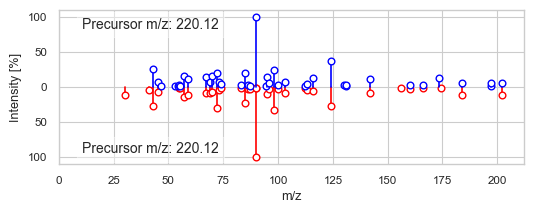

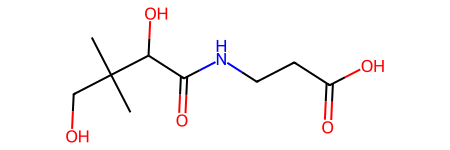


▶ Query #342 ↔ Library ID MassSpecGymID0089041 (top 1)
   DreaMS similarity:          0.981
   Modified cosine similarity: 0.970
   Query precursor m/z:  220.1183
   Library precursor m/z: 220.1180


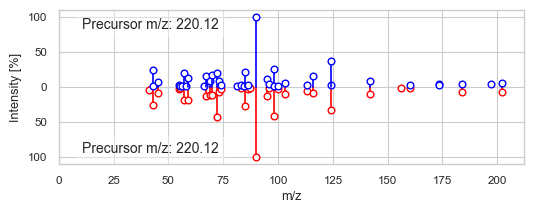

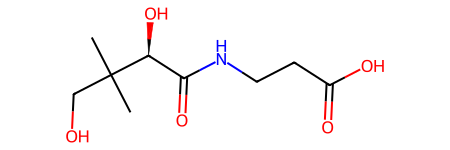


▶ Query #339 ↔ Library ID MassSpecGymID0089041 (top 1)
   DreaMS similarity:          0.980
   Modified cosine similarity: 0.963
   Query precursor m/z:  220.1183
   Library precursor m/z: 220.1180


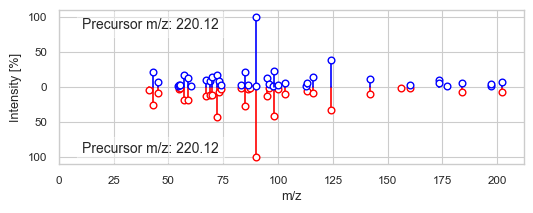

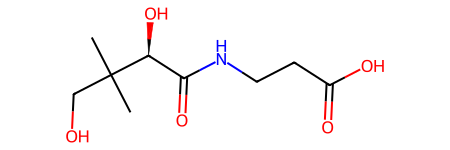


▶ Query #343 ↔ Library ID MassSpecGymID0089041 (top 1)
   DreaMS similarity:          0.980
   Modified cosine similarity: 0.968
   Query precursor m/z:  220.1183
   Library precursor m/z: 220.1180


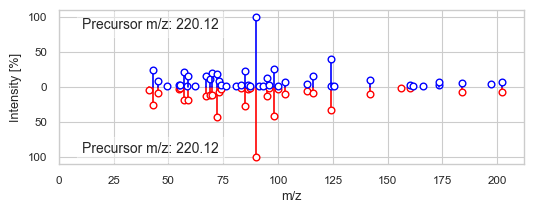

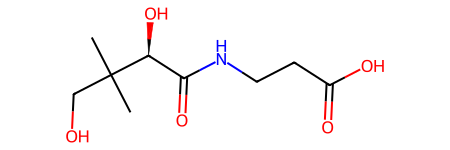


▶ Query #338 ↔ Library ID MassSpecGymID0089069 (top 1)
   DreaMS similarity:          0.979
   Modified cosine similarity: 0.826
   Query precursor m/z:  220.1183
   Library precursor m/z: 220.1180


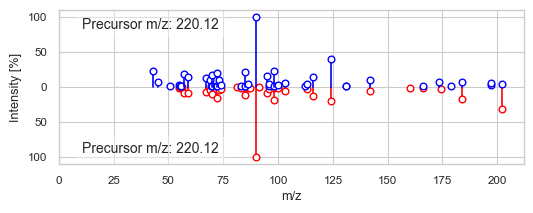

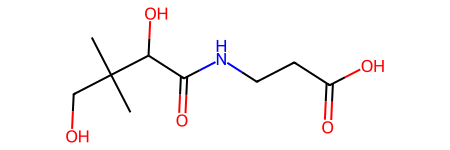


▶ Query #341 ↔ Library ID MassSpecGymID0089041 (top 1)
   DreaMS similarity:          0.977
   Modified cosine similarity: 0.963
   Query precursor m/z:  220.1184
   Library precursor m/z: 220.1180


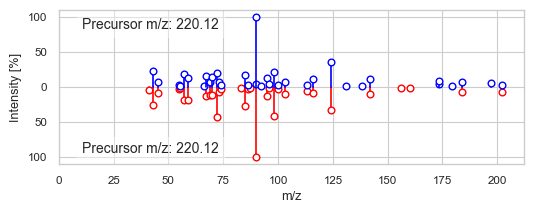

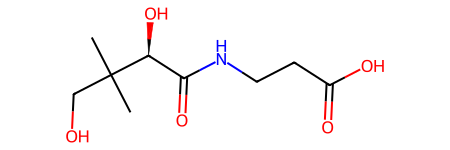


▶ Query #602 ↔ Library ID MassSpecGymID0062990 (top 1)
   DreaMS similarity:          0.977
   Modified cosine similarity: 0.994
   Query precursor m/z:  291.0867
   Library precursor m/z: 291.0860


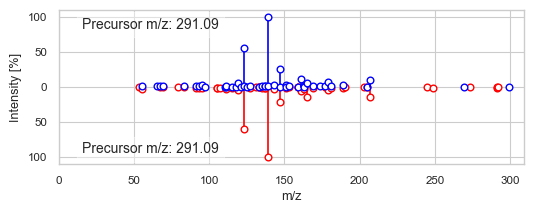

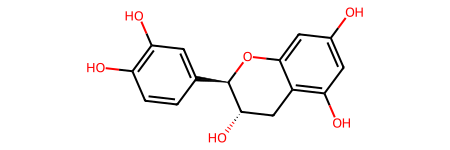


▶ Query #337 ↔ Library ID MassSpecGymID0089041 (top 1)
   DreaMS similarity:          0.977
   Modified cosine similarity: 0.966
   Query precursor m/z:  220.1183
   Library precursor m/z: 220.1180


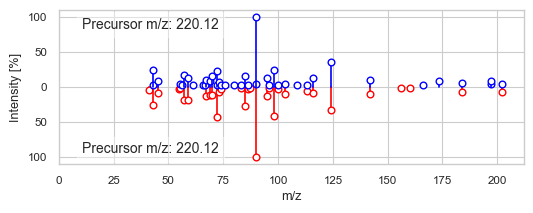

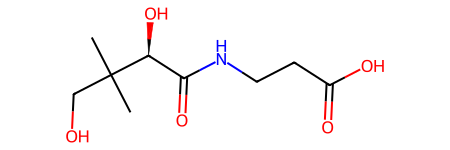


▶ Query #1632 ↔ Library ID MassSpecGymID0036861 (top 1)
   DreaMS similarity:          0.974
   Modified cosine similarity: 0.998
   Query precursor m/z:  286.1441
   Library precursor m/z: 286.1438


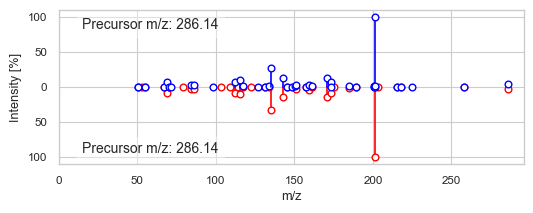

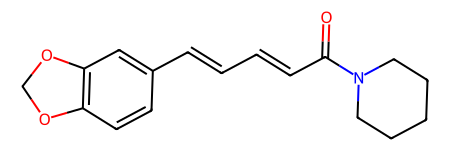


▶ Query #332 ↔ Library ID MassSpecGymID0060844 (top 1)
   DreaMS similarity:          0.972
   Modified cosine similarity: 0.966
   Query precursor m/z:  220.1184
   Library precursor m/z: 220.1179


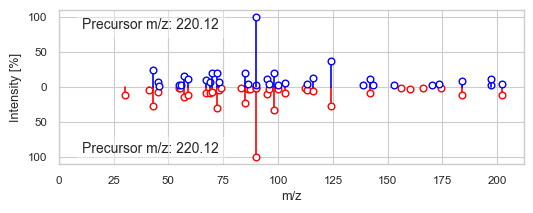

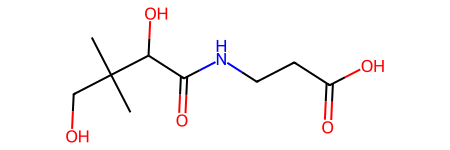

In [21]:
for row in top10.itertuples():
    qi    = int(row.query_index)
    rank  = row.rank
    li    = int(row.library_index)
    lib_id = row.library_IDENTIFIER
    dsim  = row.DreaMS_similarity
    mcos  = row.Modified_cosine_similarity

    print(f"\n▶ Query #{qi} ↔ Library ID {lib_id} (top {rank})")
    print(f"   DreaMS similarity:          {dsim:.3f}")
    print(f"   Modified cosine similarity: {mcos:.3f}")
    print(f"   Query precursor m/z:  {msdata_q.get_prec_mzs(qi):.4f}")
    print(f"   Library precursor m/z: {msdata_lib.get_prec_mzs(li):.4f}")

    su.plot_spectrum(
        spec=msdata_q.get_spectra(qi),
        mirror_spec=msdata_lib.get_spectra(li),
        prec_mz=msdata_q.get_prec_mzs(qi),
        mirror_prec_mz=msdata_lib.get_prec_mzs(li),
    )
    display(Chem.MolFromSmiles(row.library_SMILES))

## 12. Inspecting a low-confidence library match

Not every **query spectrum** will find a **perfect match** in the library.  
**DreaMS embeddings** allow us to still extract **molecular insight** even when the highest similarity is modest.

Here, we select the **query with the lowest top-1 DreaMS similarity**, retrieve its **top-5 library candidates**, and inspect the **patterns among these hits**.

In [22]:
# Identify the query spectrum with the lowest top-1 DreaMS similarity
df1 = df_matches[df_matches["rank"] == 1]
worst1 = df1.nsmallest(1, "DreaMS_similarity").iloc[0]
qi = int(worst1.query_index)
print(f"Query #{qi} has lowest top-1 DreaMS similarity: {worst1.DreaMS_similarity:.3f}")

Query #47 has lowest top-1 DreaMS similarity: 0.394



▶ Query #47 ↔ Library ID MassSpecGymID0071861 (top 1)
   DreaMS similarity:          0.394
   Modified cosine similarity: 0.028
   Query precursor m/z:        200.9733
   Library precursor m/z:      282.9439


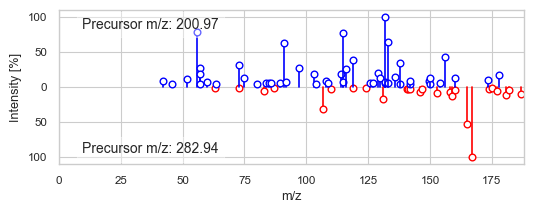

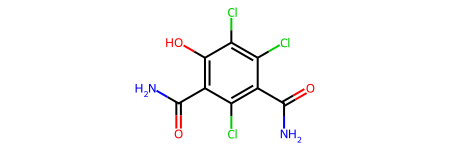


▶ Query #47 ↔ Library ID MassSpecGymID0251236 (top 2)
   DreaMS similarity:          0.394
   Modified cosine similarity: 0.311
   Query precursor m/z:        200.9733
   Library precursor m/z:      196.0220


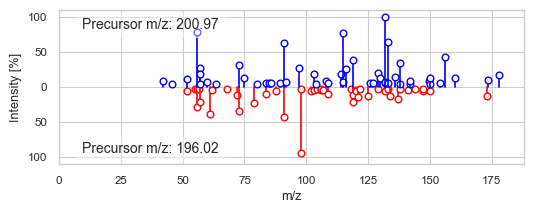

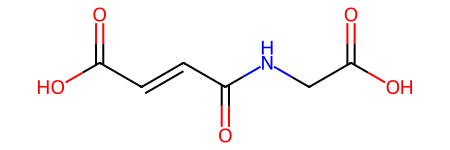


▶ Query #47 ↔ Library ID MassSpecGymID0049910 (top 3)
   DreaMS similarity:          0.384
   Modified cosine similarity: 0.139
   Query precursor m/z:        200.9733
   Library precursor m/z:      254.9734


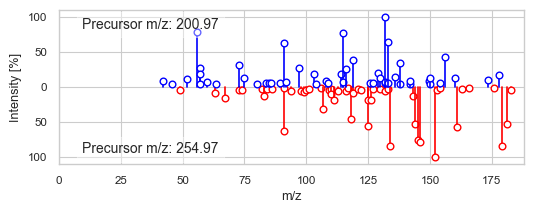

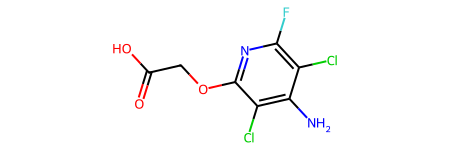


▶ Query #47 ↔ Library ID MassSpecGymID0071859 (top 4)
   DreaMS similarity:          0.379
   Modified cosine similarity: 0.042
   Query precursor m/z:        200.9733
   Library precursor m/z:      282.9439


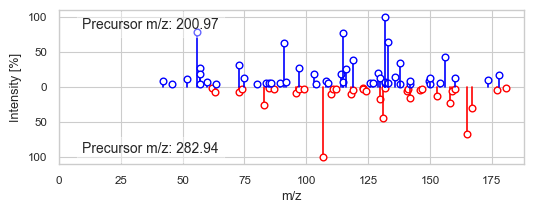

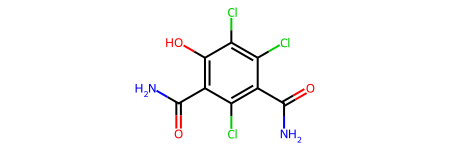


▶ Query #47 ↔ Library ID MassSpecGymID0071860 (top 5)
   DreaMS similarity:          0.376
   Modified cosine similarity: 0.061
   Query precursor m/z:        200.9733
   Library precursor m/z:      282.9439


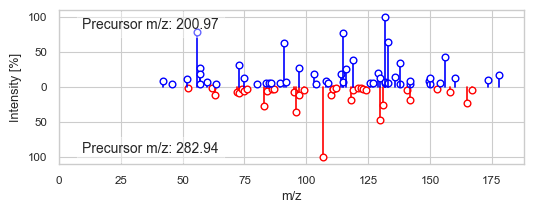

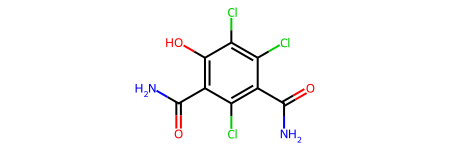

In [23]:
# Retrieve its top-5 library matches (rank 1–5)
df_worst = df_matches[df_matches["query_index"] == qi].sort_values("rank")

for row in df_worst.itertuples():
    rank = row.rank
    lib_id = row.library_IDENTIFIER
    dsim = row.DreaMS_similarity
    mcos = row.Modified_cosine_similarity
    print(f"\n▶ Query #{qi} ↔ Library ID {lib_id} (top {rank})")
    print(f"   DreaMS similarity:          {dsim:.3f}")
    print(f"   Modified cosine similarity: {mcos:.3f}")
    print(f"   Query precursor m/z:        {msdata_q.get_prec_mzs(qi):.4f}")
    print(f"   Library precursor m/z:      {msdata_lib.get_prec_mzs(row.library_index):.4f}")
    su.plot_spectrum(
        spec=msdata_q.get_spectra(qi),
        mirror_spec=msdata_lib.get_spectra(row.library_index),
        prec_mz=msdata_q.get_prec_mzs(qi),
        mirror_prec_mz=msdata_lib.get_prec_mzs(row.library_index),
    )
    display(Chem.MolFromSmiles(row.library_SMILES))

### 12.1 Interpreting low-confidence library matches

While the **query spectrum** cannot be confidently annotated with any single known library molecule, examining the **top-5 hits** reveals informative **structural patterns**.  

In this example, although the highest **DreaMS similarity** is only **0.39** and the best **modified cosine score** is around **0.02**, we observe that **all top candidates share at least one benzene ring**, and **four out of five hits contain a chlorine atom**.

## 13. Inspecting a medium-confidence library match

Not every **query spectrum** will find a **perfect** or even **highly similar** match in the reference library.  
In many real-world scenarios, the best available hits have **intermediate DreaMS similarity scores**, reflecting the presence of **related**, though not identical, **molecular structures**.

Below, we select the **query whose top-ranked DreaMS similarity falls near the median** of all matches, and examine its **top-5 library candidates**:

In [19]:
df1 = df_matches[df_matches["rank"] == 1].sort_values("DreaMS_similarity")
mid_idx = len(df1) // 2
med1 = df1.iloc[mid_idx]
qi_med = int(med1.query_index)
print(f"Query #{qi_med} has median top-1 DreaMS similarity: {med1.DreaMS_similarity:.3f}")

df_med = df_matches[df_matches["query_index"] == qi_med].sort_values("rank")

Query #845 has median top-1 DreaMS similarity: 0.648



▶ Query #845 ↔ Library ID MassSpecGymID0230536 (top 1)
   DreaMS similarity:          0.648
   Modified cosine similarity: 0.720
   Query precursor m/z:  316.1911
   Library precursor m/z: 301.1434


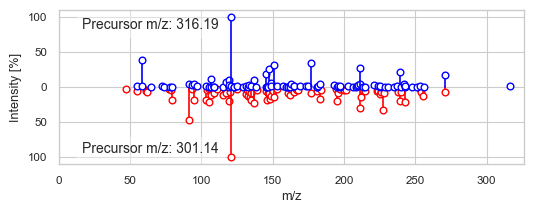

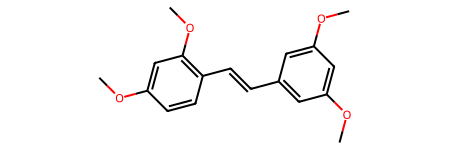


▶ Query #845 ↔ Library ID MassSpecGymID0188559 (top 2)
   DreaMS similarity:          0.647
   Modified cosine similarity: 0.745
   Query precursor m/z:  316.1911
   Library precursor m/z: 314.1750


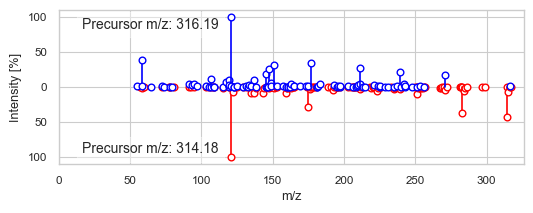

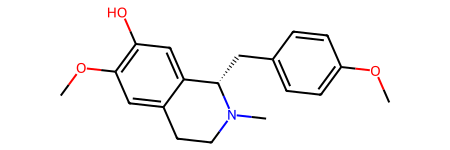


▶ Query #845 ↔ Library ID MassSpecGymID0188560 (top 3)
   DreaMS similarity:          0.647
   Modified cosine similarity: 0.745
   Query precursor m/z:  316.1911
   Library precursor m/z: 314.1750


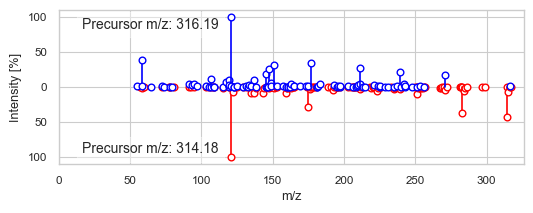

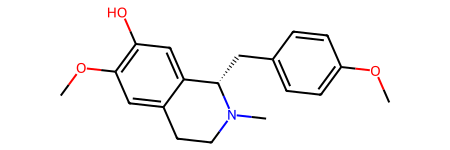


▶ Query #845 ↔ Library ID MassSpecGymID0402232 (top 4)
   DreaMS similarity:          0.641
   Modified cosine similarity: 0.798
   Query precursor m/z:  316.1911
   Library precursor m/z: 330.1710


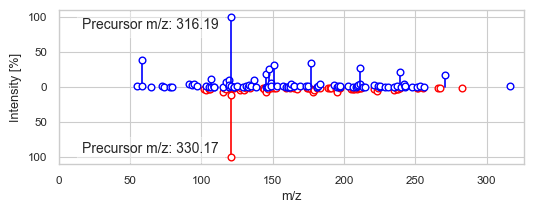

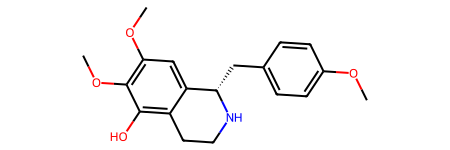


▶ Query #845 ↔ Library ID MassSpecGymID0240693 (top 5)
   DreaMS similarity:          0.620
   Modified cosine similarity: 0.525
   Query precursor m/z:  316.1911
   Library precursor m/z: 363.1950


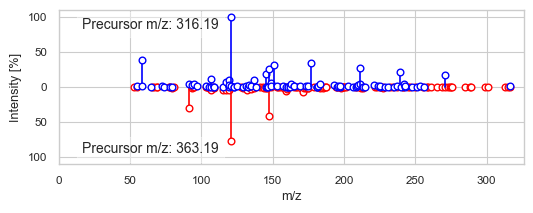

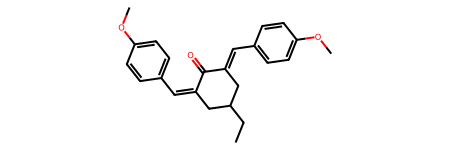

In [20]:
for row in df_med.itertuples():
    rank = row.rank
    lib_id = row.library_IDENTIFIER
    dsim = row.DreaMS_similarity
    mcos = row.Modified_cosine_similarity
    print(f"\n▶ Query #{qi_med} ↔ Library ID {lib_id} (top {rank})")
    print(f"   DreaMS similarity:          {dsim:.3f}")
    print(f"   Modified cosine similarity: {mcos:.3f}")
    print(f"   Query precursor m/z:  {msdata_q.get_prec_mzs(qi_med):.4f}")
    print(f"   Library precursor m/z: {msdata_lib.get_prec_mzs(row.library_index):.4f}")
    su.plot_spectrum(
        spec=msdata_q.get_spectra(qi_med),
        mirror_spec=msdata_lib.get_spectra(row.library_index),
        prec_mz=msdata_q.get_prec_mzs(qi_med),
        mirror_prec_mz=msdata_lib.get_prec_mzs(row.library_index),
    )
    display(Chem.MolFromSmiles(row.library_SMILES))

### 13.1 Interpretation

Medium **DreaMS similarity values** (typically **0.6–0.7**) indicate that the top-ranked library spectra are **not direct matches**, but share **meaningful structural features** with the query.  
In this example, examining the **top-5 library candidates** shows all contain **two benzene rings separated by linker regions**, a recurring motif that is likely present in the query structure as well.

The **modified cosine similarities** are moderate (~**0.7**), supporting the presence of **shared substructure** without complete identity.

**Takeaway:**  
DreaMS-based matching often surfaces **meaningful analogs** or **molecular families** even when the similarity score is not high.  
By inspecting the **chemical structures** and **recurring motifs** among top candidates, you can generate **informed hypotheses** about the **core scaffold** or **key functional groups** present in your query.